## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage
import seaborn as sn
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import backend as BK
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from livelossplot import PlotLossesKeras
from tensorflow.keras.models import Sequential

### Functions

In [6]:
def plotConfMat2(y, y_pred):
    conf_mx = confusion_matrix(y, y_pred)[:,:len(set(y_pred))]
    plt.figure(figsize=(7, 4))
    ax = sns.heatmap(conf_mx, annot=True, cmap='Blues', fmt='d')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=45)
    plt.show()
    
### display 5 images
def display_5_image(images):
    plt.figure(figsize=(10, 10))
    for images, labels in images.take(5):
        for i in range(5):
            ax = plt.subplot(5, 1, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

### mapping every number in Y truth to 1-6 with out number 5
def regression(ytr,yv,yte):
    mapping = {0:1, 1:2, 2:3,3:4, 4:6}
    ytr = np.array([mapping[key] for key in np.argmax(ytr,axis=-1)]).astype(float)
    yv = np.array([mapping[key] for key in np.argmax(yv,axis=-1)]).astype(float)
    yte = np.array([mapping[key] for key in np.argmax(yte,axis=-1)]).astype(float)
    return ytr,yv,yte

### calculate the MS error of every dataset 
def eval_regression_model(y_predict_trainre,y_train_re,y_predict_testre,y_test_re,y_val_predict_valre, y_val_re):
    print("MSE of Training Set" ,mean_squared_error(y_predict_trainre, y_train_re, squared=False))
    print("MSE of Testing Set" ,mean_squared_error(y_predict_testre,y_test_re , squared=False))
    print("MSE of Validation Set" ,mean_squared_error(y_val_predict_valre, y_val_re, squared=False))

#### function limit Y predict classes to 1-6 with out the 5
def lim(y):
    newlist=[]
    for i in y:
        if i>5.5 and i<6 or i>6:
            i=6
        elif i>5 and i<5.5:
            i=4
        elif i>0 and i<1:
            i=1
        newlist.append(i)
    return np.array(newlist).astype(int)
def split(cont):
    image = np.concatenate([x for x,y in cont], axis =0)
    label = np.concatenate([y for x,y in cont], axis =0)
    return image,label

### Reading and Split Data

In [3]:
# Prepare your dataset here
train = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/mm/Desktop/Computer Vision Final Project/Computer Vision 3/training',
    label_mode='categorical',
  image_size=(128,128),
  validation_split=0.2,
  subset='training',
  batch_size=64,
seed =123)

val = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/mm/Desktop/Computer Vision Final Project/Computer Vision 3/training',
    label_mode='categorical',
  image_size=(128,128),
  validation_split=0.2,
  subset='validation',
  batch_size=64,
seed =123)

test = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/mm/Desktop/Computer Vision Final Project/Computer Vision 3/testing' ,
    label_mode='categorical',
  image_size=(128, 128),
  batch_size=64,
seed=123)

Found 900 files belonging to 5 classes.
Using 720 files for training.
Found 900 files belonging to 5 classes.
Using 180 files for validation.
Found 100 files belonging to 5 classes.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalizedtrain_ds_res = train.map(lambda x, y: (normalization_layer(x), y))
normalizedval_ds_res = val.map(lambda x, y: (normalization_layer(x), y))
normalizedtest_ds_res = test.map(lambda x, y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in thestatement where they are used, or at least in the same block.https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
normalizedtrain_ds_res = normalizedtrain_ds_res.cache().prefetch(buffer_size=AUTOTUNE)
normalizedval_ds_res = normalizedval_ds_res.cache().prefetch(buffer_size=AUTOTUNE)
normalizedtest_ds_res = normalizedtest_ds_res.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:

X_train,y_train=split(normalizedtrain_ds_res)
X_val,y_val=split(normalizedval_ds_res)
X_test,y_test=split(normalizedtest_ds_res)

### Plot 5 Images

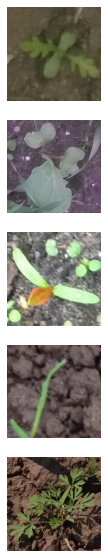

In [59]:
display_5_image(train)

## Part 1a. Transfer Learning - Classification Network 
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


### Classification Model

In [8]:
from tensorflow.keras.applications import VGG16
 
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128, 3))

In [142]:
for layer in vgg_model.layers:
        layer.trainable = False

In [146]:
inp= vgg_model.layers[6].output
# inp=vgg_model.get_layer('block2_pool').output
x= Conv2D(64, kernel_size=5, activation='relu', padding='same')(inp)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation = "relu")(x)
x = Dense(64, activation = "relu")(x)
out = Dense(5, activation='softmax')(x)
Classification_model = Model(vgg_model.input, out)

Classification_model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [147]:
Classification_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

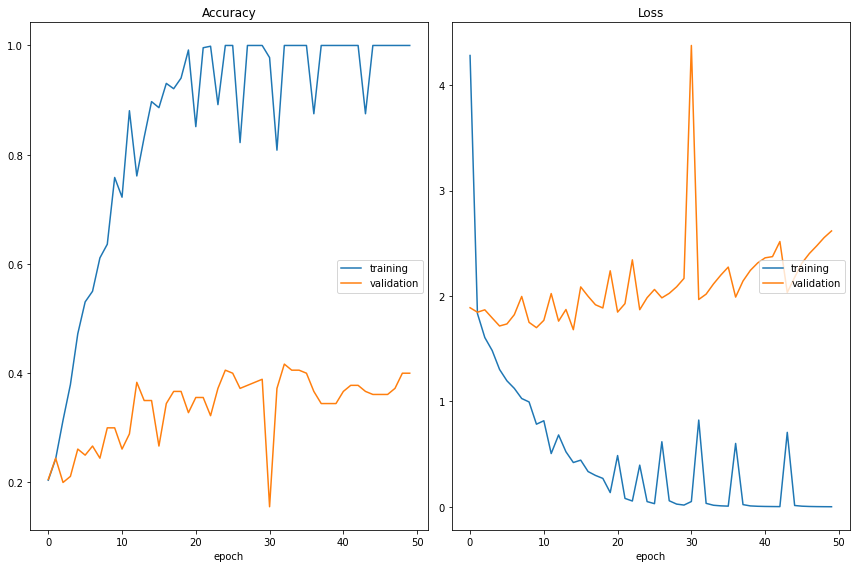

Accuracy
	training         	 (min:    0.204, max:    1.000, cur:    1.000)
	validation       	 (min:    0.156, max:    0.417, cur:    0.400)
Loss
	training         	 (min:    0.001, max:    4.282, cur:    0.001)
	validation       	 (min:    1.681, max:    4.377, cur:    2.617)
12/12 - 25s - loss: 0.0012 - acc: 1.0000 - val_loss: 2.6174 - val_acc: 0.4000 - 25s/epoch - 2s/step


In [148]:
nEpochs = 50
history = Classification_model.fit(normalizedtrain_ds_res,  epochs=nEpochs, verbose=2,validation_data=(normalizedval_ds_res),callbacks= [PlotLossesKeras()])

### Confusion Matrix for training&testing&valid


In [280]:
y_predict_prob_train = Classification_model.predict(X_train)
y_predict_train = y_predict_prob_train.argmax(axis=-1)


23/23 [==============================] - 14s 470ms/step


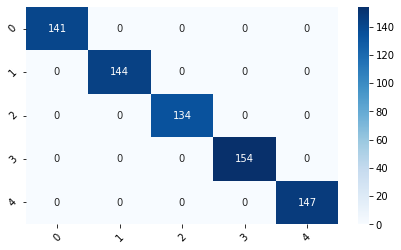

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       144
           2       1.00      1.00      1.00       134
           3       1.00      1.00      1.00       154
           4       1.00      1.00      1.00       147

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



In [282]:
plotConfMat2(y_predict_train,np.argmax(y_train,axis=-1))
print(classification_report(y_predict_train,np.argmax(y_train,axis=-1)))

In [283]:
y_predict_prob_val = Classification_model.predict(X_val)
y_predict_val = y_predict_prob_val.argmax(axis=-1)

6/6 [==============================] - 4s 540ms/step


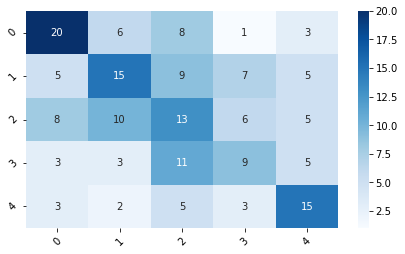

              precision    recall  f1-score   support

           0       0.51      0.53      0.52        38
           1       0.42      0.37      0.39        41
           2       0.28      0.31      0.30        42
           3       0.35      0.29      0.32        31
           4       0.45      0.54      0.49        28

    accuracy                           0.40       180
   macro avg       0.40      0.41      0.40       180
weighted avg       0.40      0.40      0.40       180



In [284]:
plotConfMat2(y_predict_val,np.argmax(y_val,axis=-1))
print(classification_report(y_predict_val,np.argmax(y_val,axis=-1)))

In [285]:
y_predict_prob_test = Classification_model.predict(X_test)
y_predict_test = y_predict_prob_test.argmax(axis=-1)

4/4 [==============================] - 2s 371ms/step


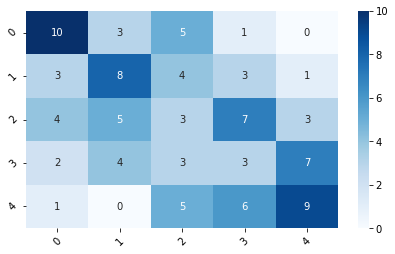

              precision    recall  f1-score   support

           0       0.50      0.53      0.51        19
           1       0.40      0.42      0.41        19
           2       0.15      0.14      0.14        22
           3       0.15      0.16      0.15        19
           4       0.45      0.43      0.44        21

    accuracy                           0.33       100
   macro avg       0.33      0.33      0.33       100
weighted avg       0.33      0.33      0.33       100



In [286]:
plotConfMat2(y_predict_test,np.argmax(y_test,axis=-1))
print(classification_report(y_predict_test,np.argmax(y_test,axis=-1)))

## Part 1b. Transfer Learning - Regression Reformulation 

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

### Single Float Value Ranging between 0 to 6

In [287]:
y_train_re,y_val_re,y_test_re=regression(y_train,y_val,y_test)

### Regression Model

In [289]:
checkpoint_path = "C:/Users/mm/Desktop/Computer Vision Final Project/Computer Vision 3/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    #save_freq = 'epoch',
    monitor = 'val_loss'
)

In [290]:
vgg_model_regression = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128, 3),classifier_activation="linear")
for layer in vgg_model_regression.layers:
        layer.trainable = False

In [291]:
#Write your code here
inp2= vgg_model.layers[6].output
# inp=vgg_model.get_layer('block2_pool').output
x= Conv2D(200, kernel_size=5, activation='relu', padding='same')(inp2)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(100, kernel_size=3, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)
out2 = Dense(1, activation='linear')(x)
Regression_model = Model(vgg_model.input, out2)
Regression_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [292]:
tf.keras.backend.clear_session()
Regression_model.compile(loss = 'mean_squared_error',optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics= ['mean_squared_error'])

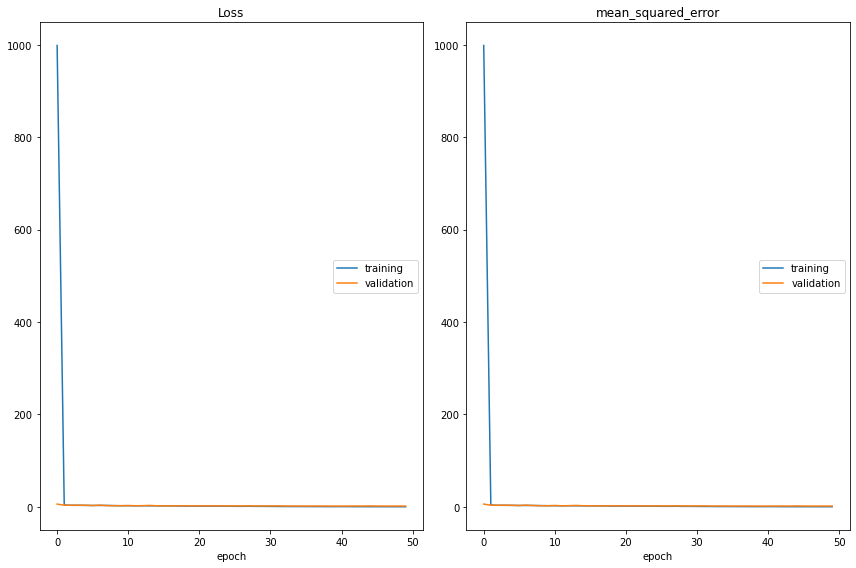

Loss
	training         	 (min:    0.075, max:  998.694, cur:    0.093)
	validation       	 (min:    1.453, max:    5.802, cur:    1.525)
mean_squared_error
	training         	 (min:    0.075, max:  998.694, cur:    0.093)
	validation       	 (min:    1.453, max:    5.802, cur:    1.525)
23/23 - 23s - loss: 0.0935 - mean_squared_error: 0.0935 - val_loss: 1.5254 - val_mean_squared_error: 1.5254 - 23s/epoch - 1s/step


In [293]:
nEpochs = 50
fit_history = Regression_model.fit(X_train,y_train_re,epochs = nEpochs,verbose = 2,callbacks = [checkpoint_callback,PlotLossesKeras()], validation_data = (X_val,y_val_re))

### Confusion Matrix for all data sets

In [407]:
y_predict_trainre = Regression_model.predict(X_train)
y_predict_testre = Regression_model.predict(X_test)
y_val_predict_valre = Regression_model.predict(X_val)

6/6 [==============================] - 6s 810ms/step


In [317]:
eval_regression_model(y_predict_trainre,y_train_re,y_predict_testre,y_test_re,y_val_predict_valre, y_val_re)

MSE of Training Set 0.27592946029443666
MSE of Testing Set 1.2689336305185686
MSE of Validation Set 1.2350525383646103


              precision    recall  f1-score   support

           1       0.66      1.00      0.79       141
           2       0.58      0.49      0.53       144
           3       0.58      0.62      0.60       134
           4       0.93      0.61      0.74       154
           6       1.00      0.95      0.98       147

    accuracy                           0.73       720
   macro avg       0.75      0.74      0.73       720
weighted avg       0.76      0.73      0.73       720



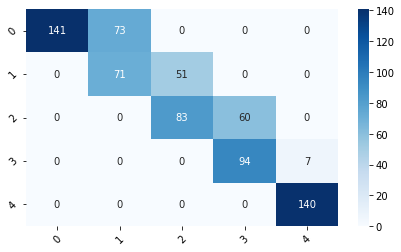

In [431]:
print(classification_report( y_train_re.astype(int),lim(y_predict_trainre)))
plotConfMat2(lim(y_predict_trainre), y_train_re.astype(int))

              precision    recall  f1-score   support

           1       0.60      0.46      0.52        26
           2       0.50      0.36      0.42        28
           3       0.15      0.15      0.15        20
           4       0.45      0.45      0.45        20
           6       0.30      1.00      0.46         6

    accuracy                           0.40       100
   macro avg       0.40      0.48      0.40       100
weighted avg       0.43      0.40      0.40       100



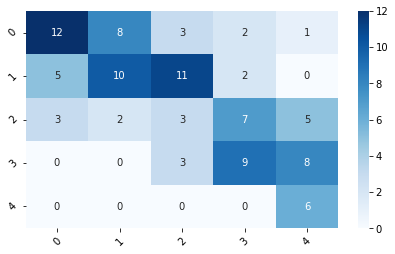

In [429]:
print(classification_report(lim(y_predict_testre),y_test_re.astype(int)))
plotConfMat2(lim(y_predict_testre),y_test_re.astype(int))

              precision    recall  f1-score   support

           1       0.64      0.58      0.61        43
           2       0.39      0.30      0.34        46
           3       0.41      0.45      0.43        42
           4       0.31      0.20      0.24        41
           6       0.21      0.88      0.34         8

    accuracy                           0.41       180
   macro avg       0.39      0.48      0.39       180
weighted avg       0.43      0.41      0.40       180



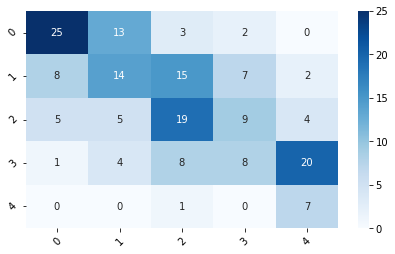

In [430]:
print(classification_report(lim(y_val_predict_valre), y_val_re.astype(int)))
plotConfMat2(lim(y_val_predict_valre), y_val_re.astype(int))

### Disscusion

Part1 (a): The classification model achieved overfit on training set 100% acc, while 40% acc on validation set and 33% acc on testing set.

           and as shown in the confusion matrix and the classification report the train set clearly overfitted, valid set all classes f-scores ranges in 30-52% with 40% acc, test set f-scores 
           in ranges 14-50%.

           The model performs well on the training data but fail to recognize the right classes on the testing and validation sets so it’s clearly overfitting.

           The model needs some improvements as it doing bad on the data.

Part1 (b): The Regression model MSE scores for the training, testing and validation.

    MSE of Training Set 0.275    MSE of Testing Set 1.26     MSE of Validation Set 1.23.

    that mean the squared distance between the actual points and the predicted ones is quite nearly on the training while on testing and validation was a little far.

    The classification report and the confusion show some interesting results as the model achieve 73% acc and the model was able to classify almost 2 classes with high recall and the others ranges in 58-66 on the training set, testing set f-scores ranges in 15-52% with accuracy 40%, validation set f-scores 24-61% with accuracy 41%.

    The model couldn’t able to converge and recorded a bad RMSE on validation and testing sets.
    
    The model acceptable and it could be better with some optimization. 
                  Ex: increasing training epochs or adding some layers.


Choosing between the classification and regression requires more experiments as I could say regression is better but still high RMSE could lead into bad predictions. Classification with a good designed network could achieve     much better results.


## Part 2. Improve your Model 

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

### Regularization Model

In [52]:
# Write your code here
vgg_model_regularization = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128, 3))

In [53]:
for layer in vgg_model_regularization.layers:
        layer.trainable = False

In [54]:
inp3= vgg_model_regularization.layers[6].output
# inp=vgg_model.get_layer('block2_pool').output
x= Conv2D(64, kernel_size=5, activation='tanh', padding='same')(inp3)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(64, kernel_size=3, activation='tanh', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(300, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(200, activation = "relu")(x)
x = Dropout(0.02)(x)
out3= Dense(5, activation='softmax')(x)
regularization_model = Model(vgg_model_regularization.input, out3)

regularization_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

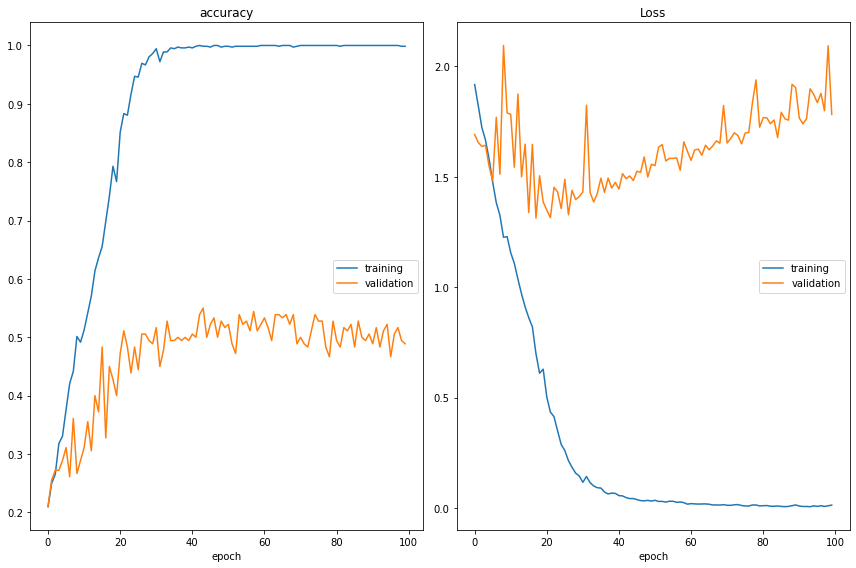

accuracy
	training         	 (min:    0.210, max:    1.000, cur:    0.999)
	validation       	 (min:    0.211, max:    0.550, cur:    0.489)
Loss
	training         	 (min:    0.005, max:    1.918, cur:    0.013)
	validation       	 (min:    1.313, max:    2.095, cur:    1.783)
23/23 - 18s - loss: 0.0127 - accuracy: 0.9986 - val_loss: 1.7829 - val_accuracy: 0.4889 - 18s/epoch - 795ms/step


In [55]:
nEpochs = 100
regularization_model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
historyL = regularization_model.fit(X_train, y_train, epochs=nEpochs, verbose=2, validation_data=(X_val, y_val),callbacks= [PlotLossesKeras()])

In [56]:
y_pred_train = regularization_model.predict(X_train)
y_pred_test = regularization_model.predict(X_test)
y_pred_val = regularization_model.predict(X_val)

6/6 [==============================] - 3s 397ms/step


In [57]:
y_predtrain_reg = y_pred_train.argmax(axis=-1)
y_predtest_reg = y_pred_test.argmax(axis=-1)
y_predval_reg = y_pred_val.argmax(axis=-1)

#### Training Confusion Matrix 

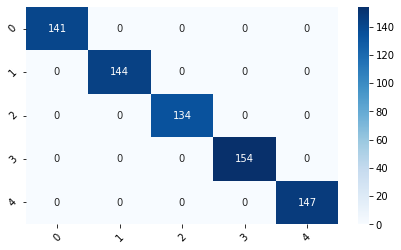

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       144
           2       1.00      1.00      1.00       134
           3       1.00      1.00      1.00       154
           4       1.00      1.00      1.00       147

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



In [58]:
plotConfMat2(y_predtrain_reg,np.argmax(y_train,axis=-1))
print(classification_report(y_predtrain_reg,np.argmax(y_train,axis=-1)))

#### Testing Confusion Matrix 

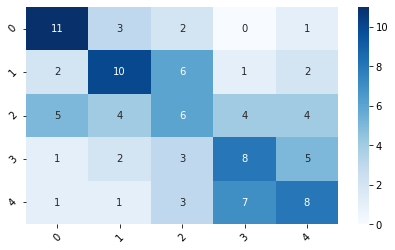

              precision    recall  f1-score   support

           0       0.55      0.65      0.59        17
           1       0.50      0.48      0.49        21
           2       0.30      0.26      0.28        23
           3       0.40      0.42      0.41        19
           4       0.40      0.40      0.40        20

    accuracy                           0.43       100
   macro avg       0.43      0.44      0.43       100
weighted avg       0.42      0.43      0.43       100



In [59]:
plotConfMat2(y_predtest_reg,np.argmax(y_test,axis=-1))
print(classification_report(y_predtest_reg,np.argmax(y_test,axis=-1)))

#### Validation Confusion Matrix 

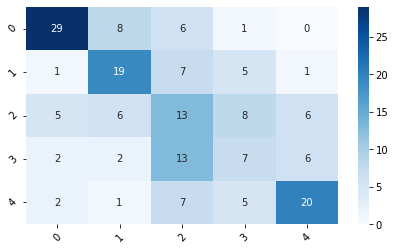

              precision    recall  f1-score   support

           0       0.74      0.66      0.70        44
           1       0.53      0.58      0.55        33
           2       0.28      0.34      0.31        38
           3       0.27      0.23      0.25        30
           4       0.61      0.57      0.59        35

    accuracy                           0.49       180
   macro avg       0.49      0.48      0.48       180
weighted avg       0.50      0.49      0.49       180



In [60]:
plotConfMat2(y_predval_reg,np.argmax(y_val,axis=-1))
print(classification_report(y_predval_reg,np.argmax(y_val,axis=-1)))

### Data Augmentation

In [19]:
imggen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        zoom_range=0.3, 
        horizontal_flip=True, 
        brightness_range=[0.2,1.5])

In [32]:
train_generator = imggen.flow_from_directory(
                  directory='C:/Users/mm/Desktop/Computer Vision Final Project/Computer Vision 3/training',
                  target_size=(128, 128), 
                  color_mode="rgb", 
                  batch_size=32, 
                  class_mode="binary",
                  seed=1 
)

Found 900 images belonging to 5 classes.


In [33]:
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

In [35]:
X_train = np.concatenate([X_train,X_val])
y_train = np.concatenate([y_train,y_val])

In [36]:
training_generator = datagen.flow(X_train,y_train, batch_size=64,subset='training',seed=7)
validation_generator = datagen.flow(X_train,y_train, batch_size=64,subset='validation',seed=7)

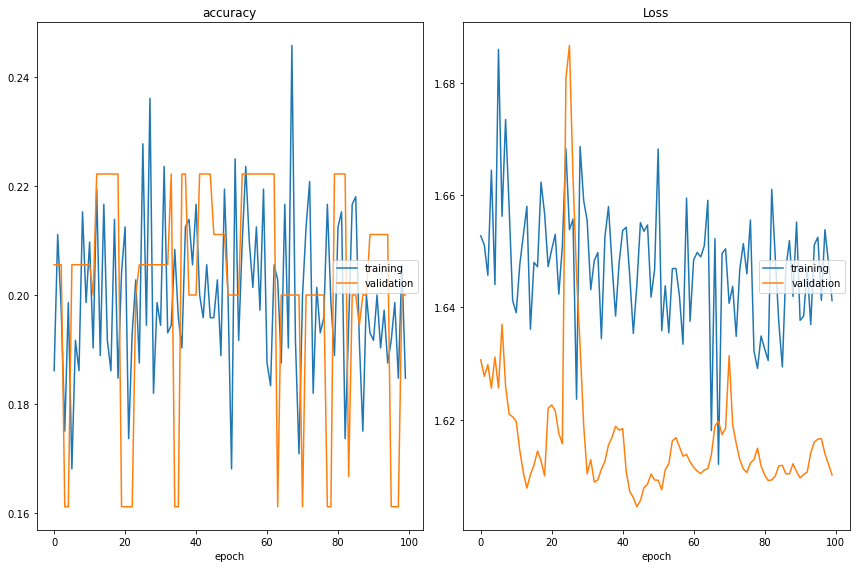

accuracy
	training         	 (min:    0.168, max:    0.246, cur:    0.185)
	validation       	 (min:    0.161, max:    0.222, cur:    0.200)
Loss
	training         	 (min:    1.612, max:    1.686, cur:    1.641)
	validation       	 (min:    1.604, max:    1.687, cur:    1.610)
12/12 [==============================] - 22s 2s/step - loss: 1.6413 - accuracy: 0.1847 - val_loss: 1.6102 - val_accuracy: 0.2000


In [45]:
historyL = regularization_model.fit(training_generator, epochs=100,validation_data=validation_generator,callbacks= [PlotLossesKeras()])

In [46]:
y_pred_train_aug = regularization_model.predict(X_train)
y_pred_test_aug = regularization_model.predict(X_test)
y_pred_val_aug = regularization_model.predict(X_val)

6/6 [==============================] - 3s 480ms/step


In [47]:
y_predtrain_reg_aug = y_pred_train_aug.argmax(axis=-1)
y_predtest_reg_aug = y_pred_test_aug.argmax(axis=-1)
y_predval_reg_aug = y_pred_val_aug.argmax(axis=-1)

#### Training Confusion Matrix 

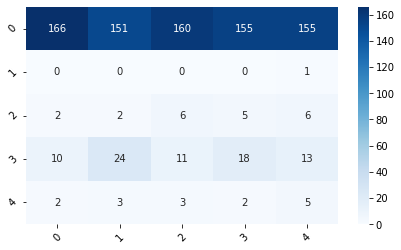

              precision    recall  f1-score   support

           0       0.92      0.21      0.34       787
           1       0.00      0.00      0.00         1
           2       0.03      0.29      0.06        21
           3       0.10      0.24      0.14        76
           4       0.03      0.33      0.05        15

    accuracy                           0.22       900
   macro avg       0.22      0.21      0.12       900
weighted avg       0.82      0.22      0.31       900



In [48]:
plotConfMat2(y_predtrain_reg_aug,np.argmax(y_train,axis=-1))
print(classification_report(y_predtrain_reg_aug,np.argmax(y_train,axis=-1)))

#### Testing Confusion Matrix 

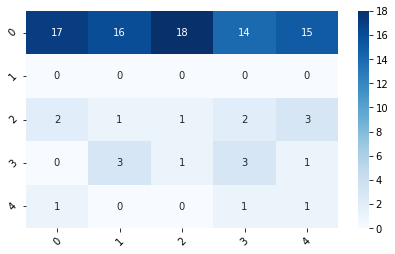

              precision    recall  f1-score   support

           0       0.85      0.21      0.34        80
           1       0.00      0.00      0.00         0
           2       0.05      0.11      0.07         9
           3       0.15      0.38      0.21         8
           4       0.05      0.33      0.09         3

    accuracy                           0.22       100
   macro avg       0.22      0.21      0.14       100
weighted avg       0.70      0.22      0.30       100



In [49]:
plotConfMat2(y_predtest_reg_aug,np.argmax(y_test,axis=-1))
print(classification_report(y_predtest_reg_aug,np.argmax(y_test,axis=-1)))

#### Validation Confusion Matrix 

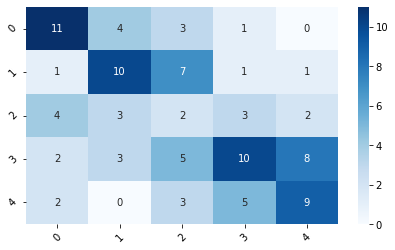

              precision    recall  f1-score   support

           0       0.55      0.58      0.56        19
           1       0.50      0.50      0.50        20
           2       0.10      0.14      0.12        14
           3       0.50      0.36      0.42        28
           4       0.45      0.47      0.46        19

    accuracy                           0.42       100
   macro avg       0.42      0.41      0.41       100
weighted avg       0.44      0.42      0.43       100



In [50]:
plotConfMat2(y_predtest_reg,np.argmax(y_test,axis=-1))
print(classification_report(y_predtest_reg,np.argmax(y_test,axis=-1)))

### Disscusion

Part2 (step1): The model got 100% on the training set and 55% on the validation set.

               The confusion matrix and the report show that the model overfitted on the training, while on the testing acc 43%, validation acc 49%. 

               The model stucked in the 47-53 ranges during training and didn’t converge any more knowledge to be better. 

               As Shown in the confusion matrix and the report for validation data the model scored bad accuracies during the training process and model cannot converge on validation data.

               It’s clearly overfitting again.

Regularization improve the valid accuracy and the test accuracy from 33% to 43% and the validation from 40% to 49%



Part2 (step2): The confusion matrix shows a bad result during the classification a huge overlap in the missed classification classes.

               The classification report shows bad accuracies on both train and test 22%, but the valid set accuracy was 42%.

               That could be due to the concept drift where we changed the data with some processes.
               Ex: zooming, shifting, rotating.

Data Augmentation didn't help in improving the accuracy over the training data as the model wasn't able to learn well as the model accuracy keep change between 2 peaks 16-24 %.



## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.